In [4]:
import glob
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values

In [6]:
train_history = load_multiple_metrics("toy1d_experiment0_protocol_test", "toy1d_train_history")

In [7]:
variations = ["Base", "SensorialMask", "CompleteProtocol"]
n_epoch = len(train_history[variations[0]]["means"]["optimizer_loss_train"])

color_map = {
    "Base":"#60BF60",
    "SensorialMasker":"#D36767",
    "CompleteProtocol":"#6060BF"
}

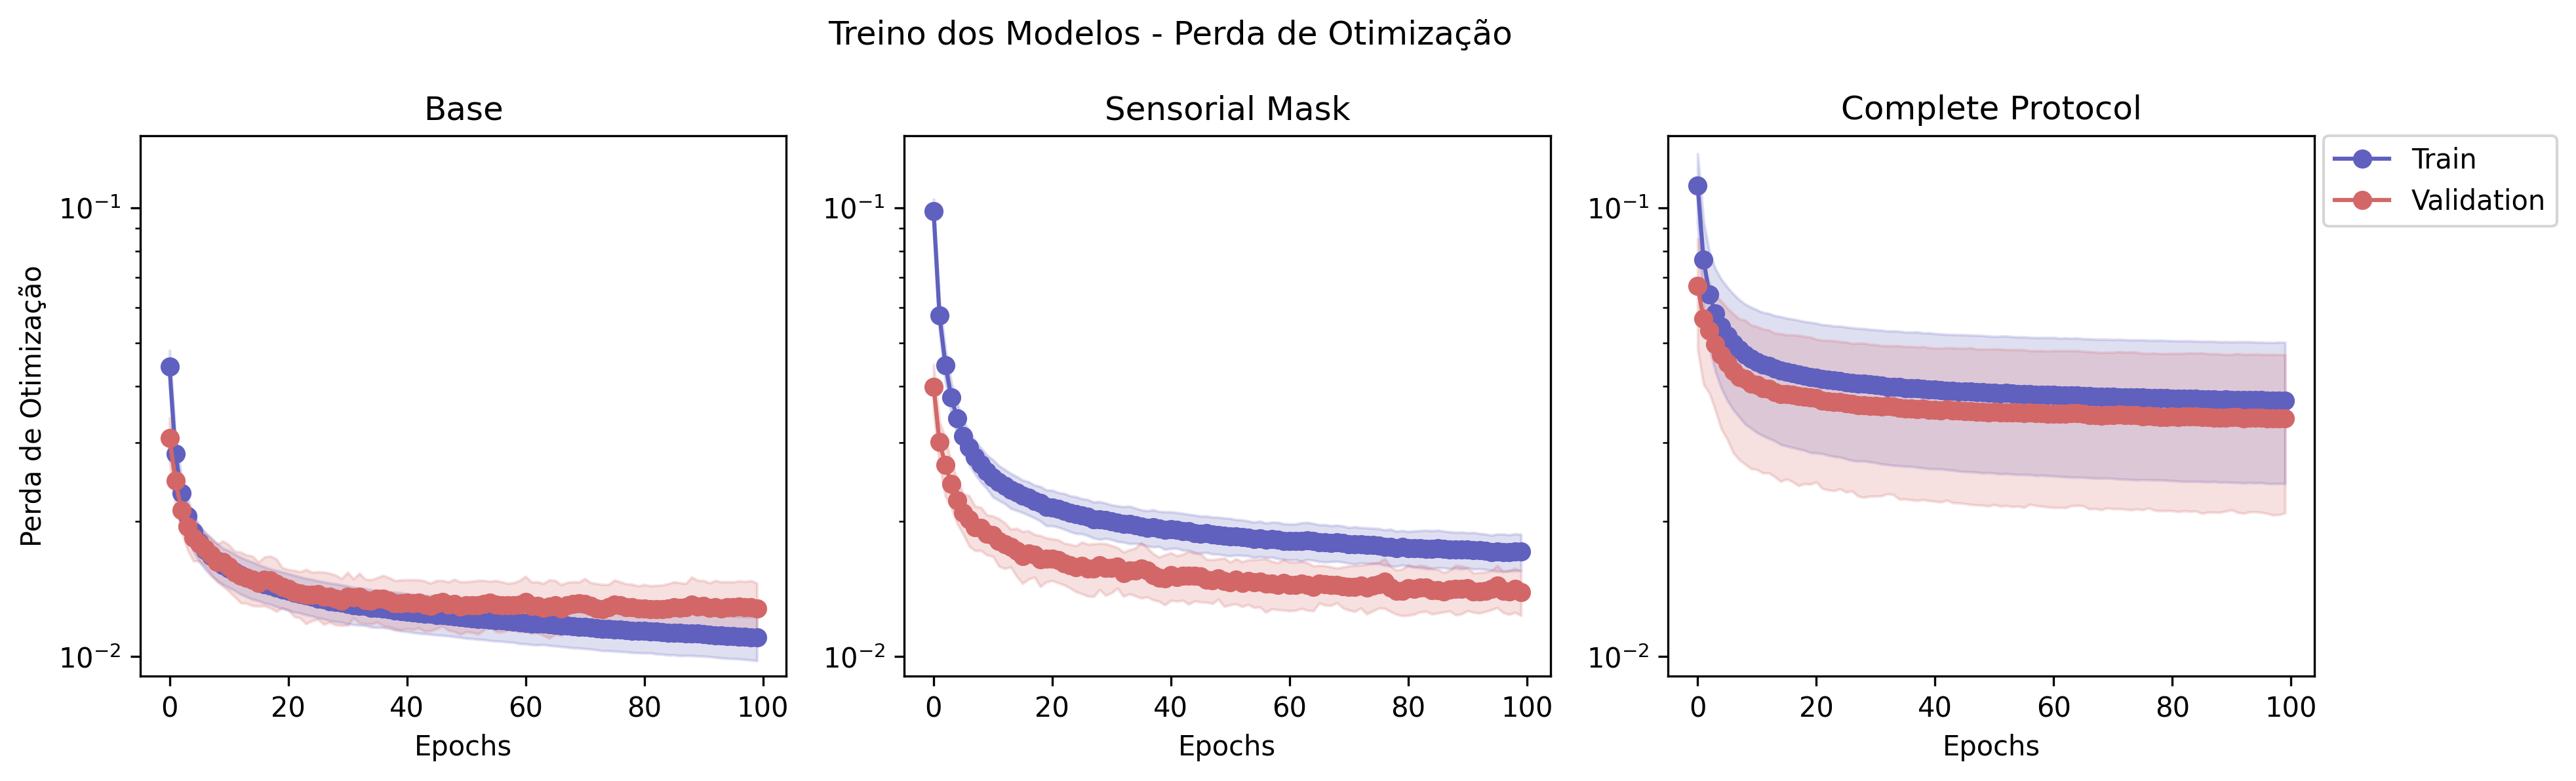

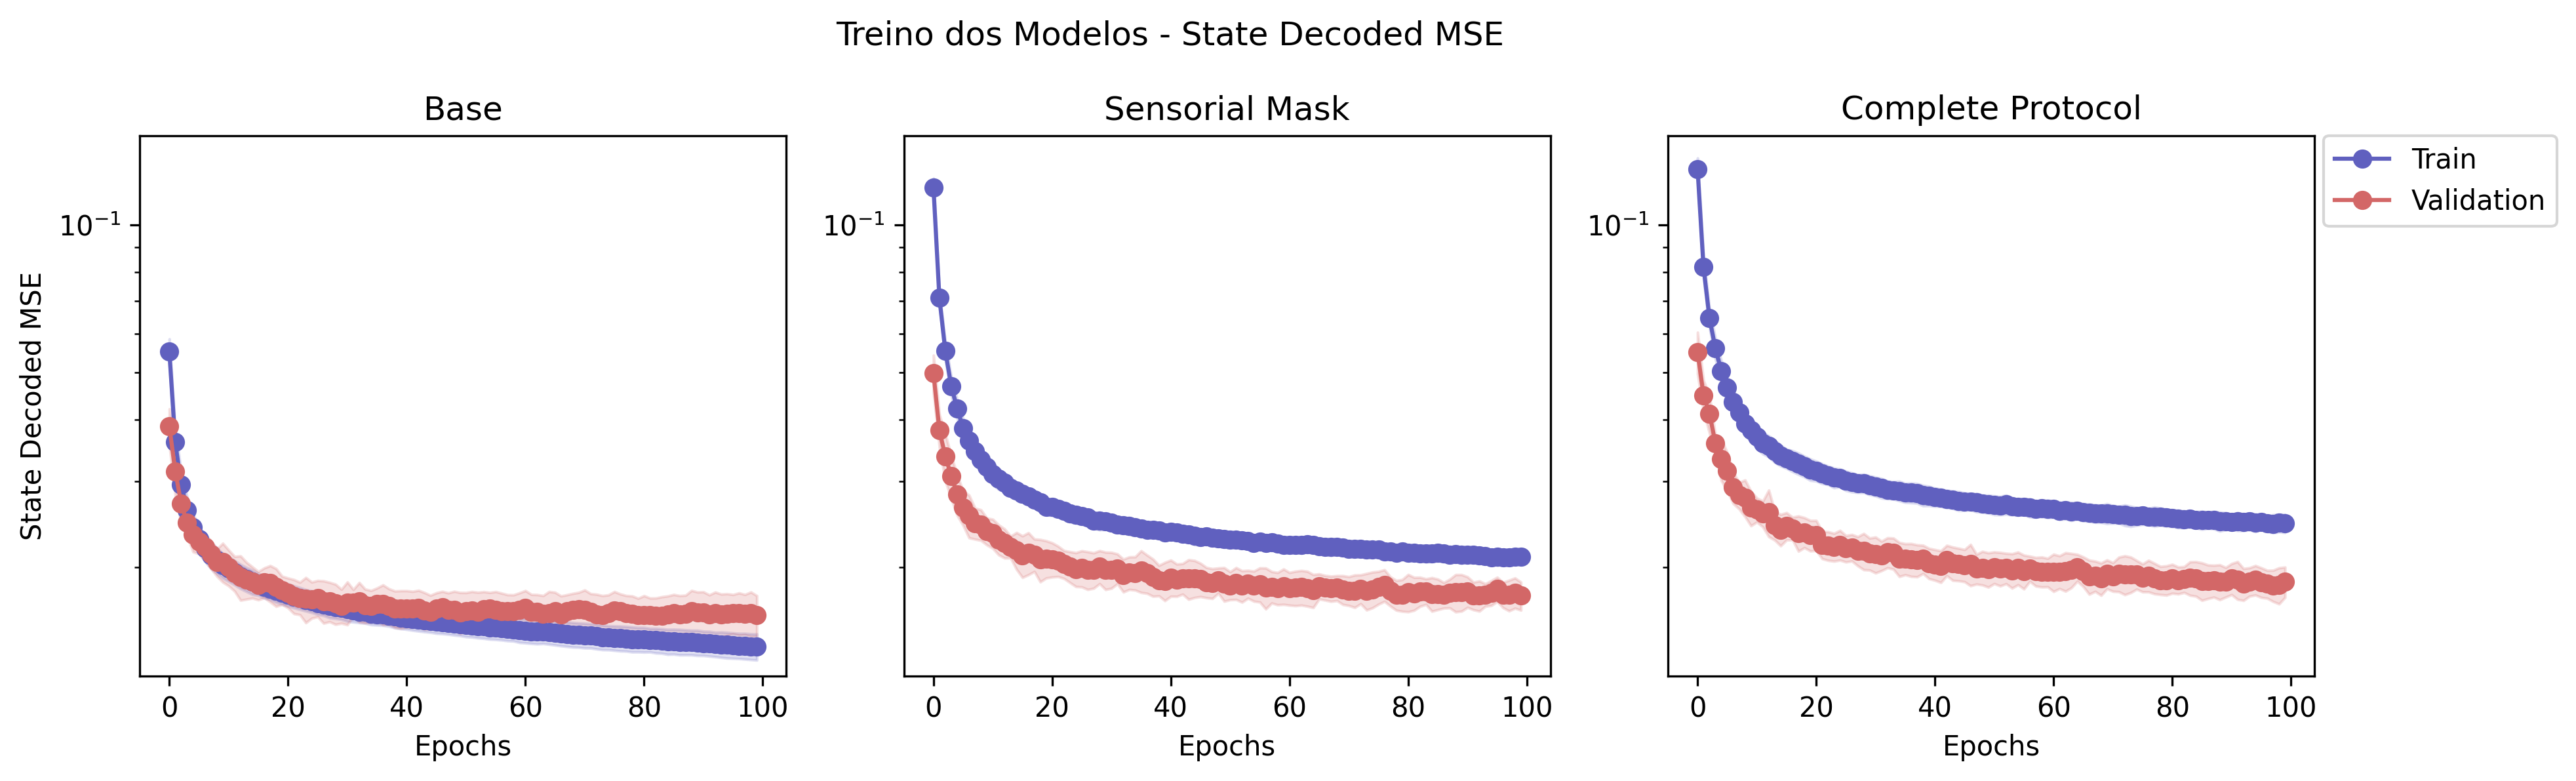

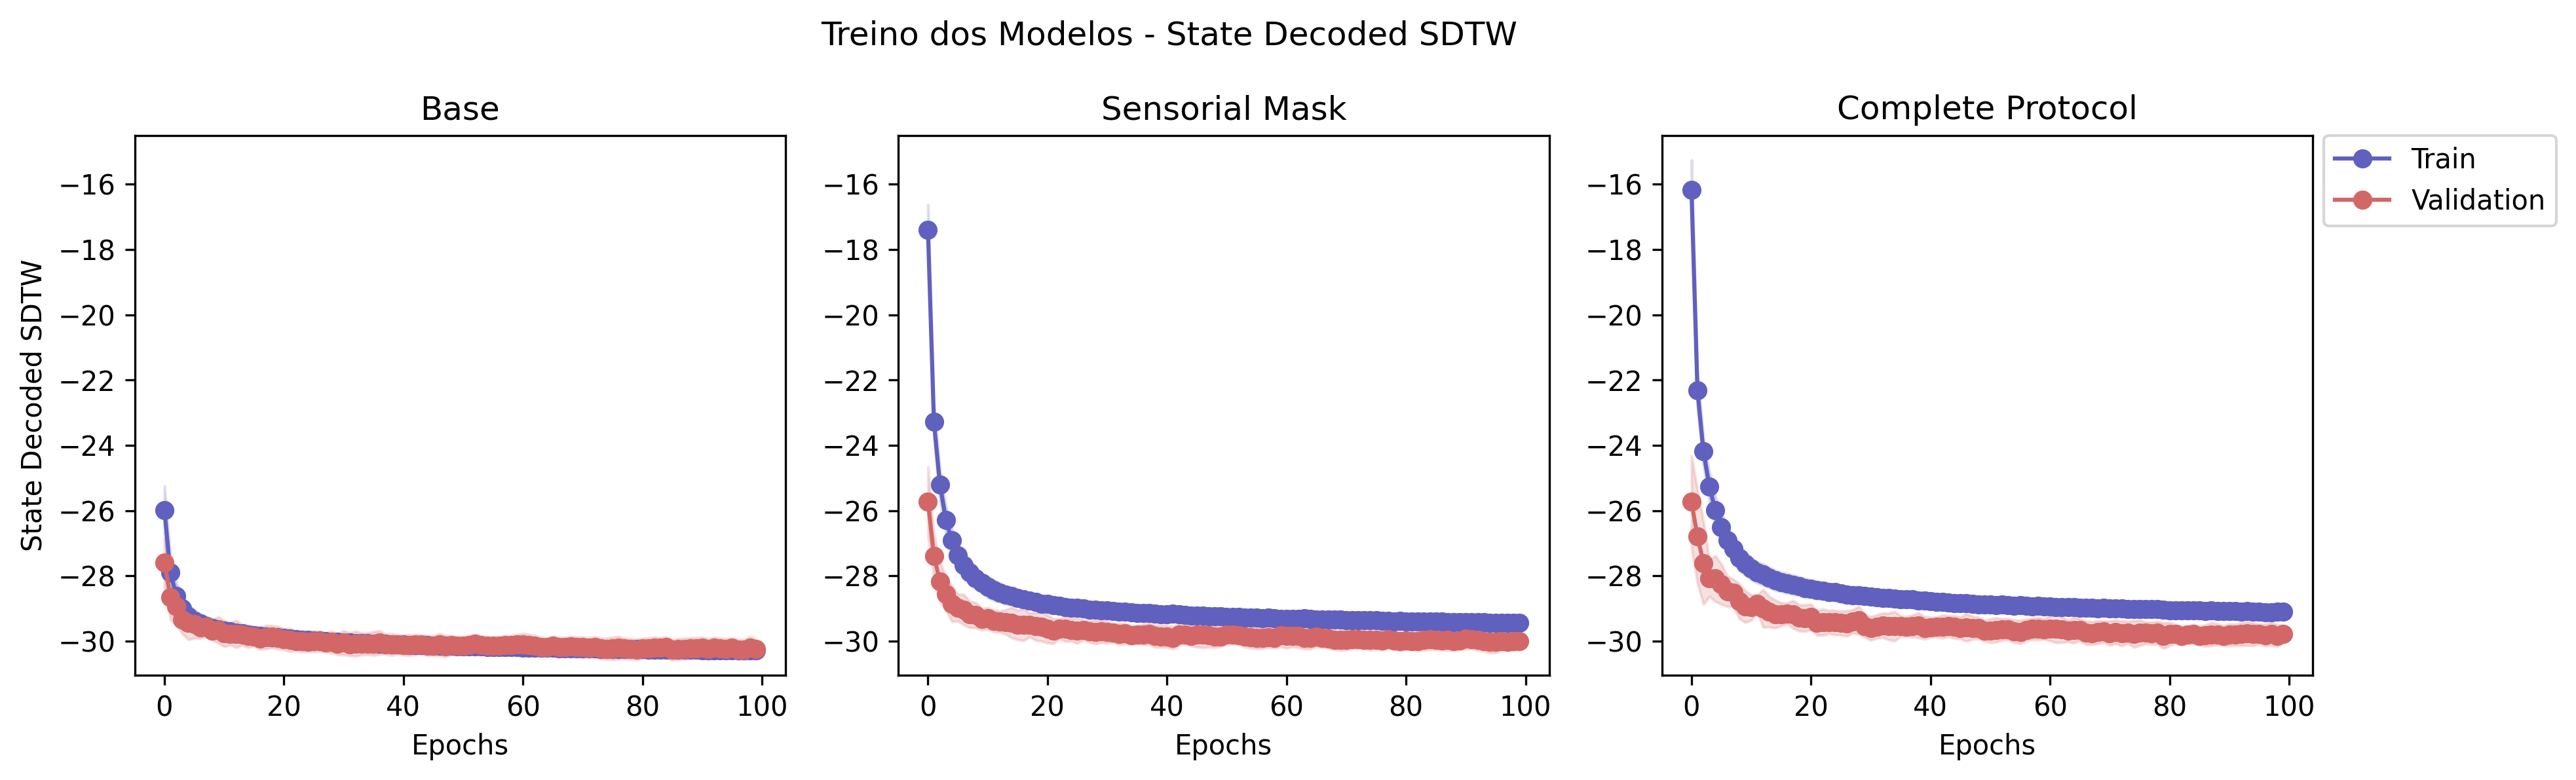

In [8]:
epochs = range(n_epoch)

figures = {}

from matplotlib.axes import Axes
from matplotlib.figure import Figure

metrics = ["optimizer_loss", "state_decoded_mse", "state_decoded_sdtw"]
ylabels = ["Perda de Otimização", "State Decoded MSE", "State Decoded SDTW"]

for i in range(len(metrics)):
    metric_name = metrics[i]
    ylabel = ylabels[i]
    plot_name = metric_name+"_train_history"

    fig, axs = plt.subplots(1, 3, dpi=300, figsize=(12,4))
    axs:list[Axes]

    for j, name in enumerate(variations):

        means = train_history[name]["means"][f"{metric_name}_train"]
        stds = train_history[name]["stds"][f"{metric_name}_train"]
        
        axs[j].plot(epochs, means, "o-", label="Train", color=color_map["CompleteProtocol"])
        axs[j].fill_between(epochs, means-stds, means+stds, color=color_map["CompleteProtocol"], alpha=.2)

        means = train_history[name]["means"][f"{metric_name}_val"]
        stds = train_history[name]["stds"][f"{metric_name}_val"]
        
        axs[j].plot(epochs, means, "o-", label="Validation", color=color_map["SensorialMasker"])
        axs[j].fill_between(epochs, means-stds, means+stds, color=color_map["SensorialMasker"], alpha=.2)

        #axs[j].errorbar(epochs, train_history[name]["means"]["optimizer_loss_train"], train_history[name]["stds"]["optimizer_loss_train"],  fmt="o-", label="Train", color=color_map["CompleteProtocol"])
        #axs[j].errorbar(epochs, train_history[name]["means"]["optimizer_loss_val"], train_history[name]["stds"]["optimizer_loss_val"],  fmt="o-", label="Validation", color=color_map["SensorialMasker"])

        axs[j].set_xlabel("Epochs")

        if j == 0:
            axs[j].set_ylabel(ylabel)

        if i != 2:
    
            axs[j].set_yscale("log")

        

        name = " ".join(re.sub( r"([A-Z])|(\d+)", r" \1\2", name).split())
        axs[j].set_title(name)


    maximum = -np.inf
    minimum = np.inf

    for ax in axs:
        maximum = max(maximum, ax.get_ylim()[1])
        minimum = min(minimum, ax.get_ylim()[0])

    for ax in axs:
        ax.set_ylim(minimum, maximum)

    plt.suptitle(f"Treino dos Modelos - {ylabel}")
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.375, 1), borderaxespad=0)

    figures[plot_name] = fig

    plt.show()

In [9]:
metrics = load_multiple_metrics("toy1d_experiment0_protocol_test", "toy1d_metrics")

In [12]:
state_decoded_mse = get_values(metrics, ["means", "normal", "state_decoded_mse"])
state_decoded_mse_std = get_values(metrics, ["stds", "normal", "state_decoded_mse"])

In [18]:
def test_func(a):
    return state_decoded_mse-state_decoded_mse_std, state_decoded_mse+state_decoded_mse_std

In [23]:
state_decoded_mse_normal = get_values(metrics, ["means", "normal", "state_decoded_mse"])
state_decoded_mse_prediction = get_values(metrics, ["means", "prediction", "state_decoded_mse"])

state_decoded_mse = np.array([state_decoded_mse_normal, state_decoded_mse_prediction])
state_decoded_mse

array([[0.00541298, 0.0057134 , 0.00541596],
       [0.17132537, 0.06756666, 0.06352227]])

In [46]:
import pandas as pd

df_metrics = []

for i in range(3):
    
    
    for metric_name in ["normal", "use_state", "prediction", "prediction_shallow"]:
        element = {}
        element["mean"] = get_values(metrics, ["means", metric_name, "state_decoded_mse"])[i]
        element["std"] = get_values(metrics, ["stds", metric_name, "state_decoded_mse"])[i]
        element["metric_name"] = metric_name
        element["variation"] = variations[i]
        

        df_metrics.append(element)


df_metrics = pd.DataFrame(df_metrics)

In [47]:
df_metrics

,mean,std,metric_name,variation
0,0.005413,0.000536,normal,Base
1,0.096719,0.018451,use_state,Base
2,0.171325,0.019842,prediction,Base
3,0.158146,0.011653,prediction_shallow,Base
4,0.005713,0.000314,normal,SensorialMask
5,0.009153,0.000507,use_state,SensorialMask
6,0.067567,0.014843,prediction,SensorialMask
7,0.158973,0.012686,prediction_shallow,SensorialMask
8,0.005416,0.000366,normal,CompleteProtocol
9,0.008677,0.000601,use_state,CompleteProtocol


In [56]:
def test_func(a, b):
    print(a)
    raise ValueError

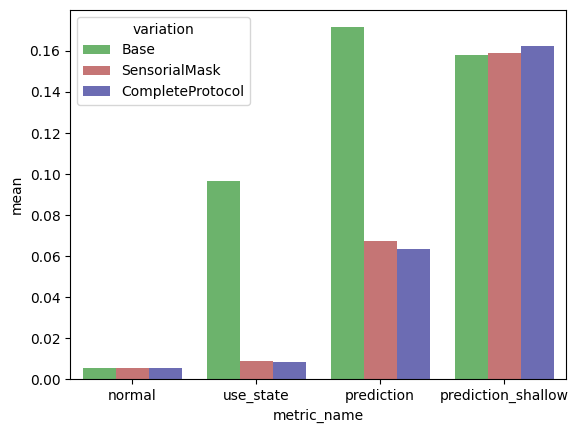

In [61]:
ax = sns.barplot(df_metrics, x="metric_name", y="mean", hue="variation", palette=list(color_map.values()))


<ErrorbarContainer object of 3 artists>

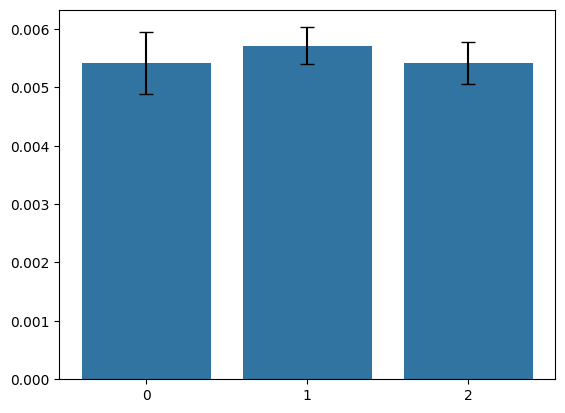

In [21]:
ax = sns.barplot(state_decoded_mse)
ax.errorbar(x=np.arange(len(state_decoded_mse)), y=state_decoded_mse, yerr=state_decoded_mse_std, fmt="None", c="black", capsize=5)